# **download Dataset**

In [ ]:
!kaggle datasets download CooperUnion/anime-recommendations-database

Dataset URL: https://www.kaggle.com/datasets/CooperUnion/anime-recommendations-database
License(s): CC0-1.0
 60% 15.0M/25.0M [00:00<00:00, 74.1MB/s]
100% 25.0M/25.0M [00:00<00:00, 88.5MB/s]


In [ ]:
!unzip /content/anime-recommendations-database.zip

Archive:  /content/anime-recommendations-database.zip
  inflating: anime.csv               
  inflating: rating.csv              


In [ ]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 2.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357282 sha256=b17107b7aab88f9d6d0769d00a4da7b610899784f1a2ce7e7e5503ca8b7caf47
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


# **load dataset**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from surprise import KNNBasic
from sklearn.metrics.pairwise import sigmoid_kernel

In [ ]:
df_anime=pd.read_csv('/content/anime.csv')
df_rating=pd.read_csv('/content/rating.csv')

In [ ]:
df_anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [ ]:
df_rating.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [ ]:
df_anime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


In [ ]:
df_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB


# **preprocessing**

In [ ]:
df_anime.isnull().sum()

,0
anime_id,0
name,0
genre,62
type,25
episodes,0
rating,230
members,0


In [ ]:
len(df_anime)

12294

In [ ]:
df_anime.dropna(subset=['rating'], inplace=True)

In [ ]:
df_anime.isnull().sum()

,0
anime_id,0
name,0
genre,47
type,0
episodes,0
rating,0
members,0


In [ ]:
df_anime.dropna(subset=['genre'], inplace=True)

In [ ]:
df_anime.isnull().sum()

,0
anime_id,0
name,0
genre,0
type,0
episodes,0
rating,0
members,0


In [ ]:
df_rating.isnull().sum()

,0
user_id,0
anime_id,0
rating,0


In [ ]:
df_anime.duplicated().sum()

0

In [ ]:
df_rating.duplicated().sum()

1

In [ ]:
df_rating.drop_duplicates(inplace=True)

In [ ]:
df_rating.duplicated().sum()

0

# **Collaborative Filtering**

In [ ]:
# Merge datasets on 'anime_id'
df = pd.merge(df_rating, df_anime, on='anime_id', how='inner')

# Rename columns to avoid confusion
df.rename(columns={'rating_x': 'user_rating', 'rating_y': 'anime_avg_rating'}, inplace=True)

In [ ]:
# Filter out rows where 'user_rating' is -1
df = df[df['user_rating'] != -1]

# Drop any NaN values in 'user_rating'
df.dropna(subset=['user_rating'], inplace=True)

In [ ]:
# Create unique mappings for user_id and anime_id
users = df['user_id'].unique()
animes = df['anime_id'].unique()
user_map = {user: idx for idx, user in enumerate(users)}
anime_map = {anime: idx for idx, anime in enumerate(animes)}

# Map user_ids and anime_ids to their indices
df['user_idx'] = df['user_id'].map(user_map)
df['anime_idx'] = df['anime_id'].map(anime_map)

In [ ]:
from surprise import Dataset, Reader

# Prepare data for Surprise
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(df[['user_id', 'anime_id', 'user_rating']], reader)

In [ ]:
from surprise.model_selection import train_test_split
from surprise import SVD

# Split the data
trainset, testset = train_test_split(data, test_size=0.2)

# Train an SVD model
algo = SVD()
algo.fit(trainset)

# Make predictions
predictions = algo.test(testset)

In [ ]:
from surprise import accuracy

# Evaluate the model
print("RMSE:", accuracy.rmse(predictions))
print("MAE:", accuracy.mae(predictions))

RMSE: 1.1336
RMSE: 1.1335838813363588
MAE:  0.8454
MAE: 0.8453597114729181


In [ ]:
# Binarize actual and predicted ratings
threshold = 7
actual_binary = [1 if r >= threshold else 0 for (_, _, r) in testset]
predictions_binary = [1 if pred.est >= threshold else 0 for pred in predictions]

In [ ]:
# Check the structure of testset
print("Type of testset elements:", type(testset[0]))
print("Number of elements in testset tuple:", len(testset[0]))
print("Sample testset tuple:", testset[0])

# Check the structure of predictions
print("Type of predictions elements:", type(predictions[0]))
print("Sample prediction:", predictions[0].est)

Type of testset elements: <class 'tuple'>
Number of elements in testset tuple: 3
Sample testset tuple: (61185, 8074, 8.0)
Type of predictions elements: <class 'surprise.prediction_algorithms.predictions.Prediction'>
Sample prediction: 6.450197159035992


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate metrics
precision = precision_score(actual_binary, predictions_binary)
recall = recall_score(actual_binary, predictions_binary)
f1 = f1_score(actual_binary, predictions_binary)
accuracy = accuracy_score(actual_binary, predictions_binary)

In [ ]:
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Accuracy:", accuracy)

Precision: 0.921329310705887
Recall: 0.8788613013944127
F1-score: 0.8995943780365392
Accuracy: 0.8380532558431281


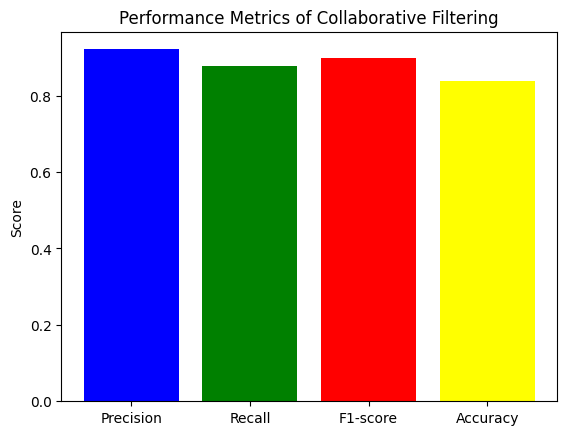

In [ ]:
import matplotlib.pyplot as plt

# Visualize the performance metrics
plt.bar(['Precision', 'Recall', 'F1-score', 'Accuracy'], [precision, recall, f1, accuracy], color=['blue', 'green', 'red','yellow'])
plt.title('Performance Metrics of Collaborative Filtering')
plt.ylabel('Score')
plt.show()

# **Content-Based Filtering**

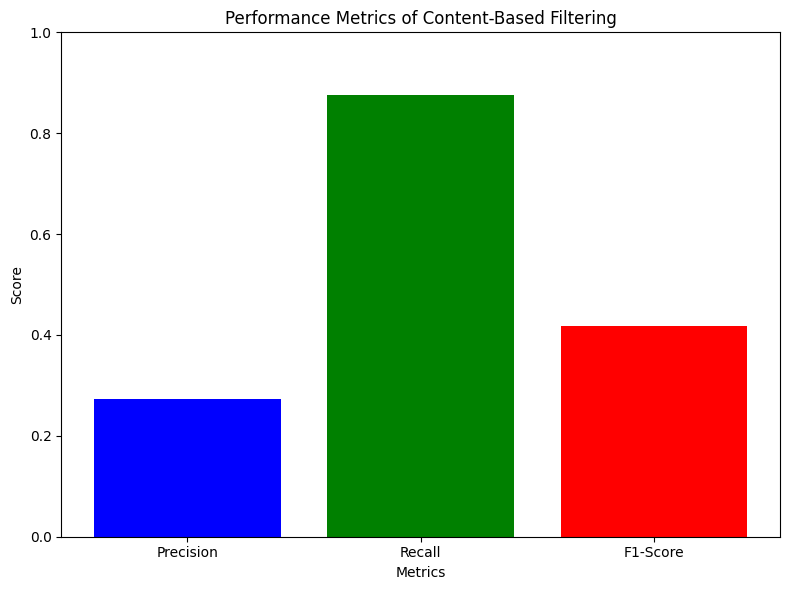

{'Precision': 0.27386934673366836, 'Recall': 0.8752676659528907, 'F1-Score': 0.41719826486348566}


In [ ]:
# Preprocessing anime data
def preprocess_anime_data(df_anime):
    df_anime = df_anime.dropna(subset=['rating', 'genre'])  # Drop rows with missing data
    df_anime['episodes'] = pd.to_numeric(df_anime['episodes'], errors='coerce')  # Convert episodes to numeric
    df_anime.loc[df_anime['type'] == 'Movie', 'episodes'] = 1
    df_anime['episodes'] = df_anime['episodes'].fillna(1).astype(int)

    # One-hot encode genres
    mlb = MultiLabelBinarizer(sparse_output=True)
    genre_matrix = mlb.fit_transform(df_anime['genre'].str.split(','))
    genre_df = pd.DataFrame.sparse.from_spmatrix(genre_matrix, columns=mlb.classes_, index=df_anime.index)

    # Encode type
    type_df = pd.get_dummies(df_anime['type'], prefix='type', sparse=True)

    # Normalize numerical features
    scaler = MinMaxScaler()
    numerical_features = ['rating', 'members', 'episodes']
    scaled_features = pd.DataFrame(scaler.fit_transform(df_anime[numerical_features]),
                                   columns=numerical_features, index=df_anime.index)

    # Combine features
    features_df = pd.concat([scaled_features, genre_df, type_df], axis=1)
    features_df['anime_id'] = df_anime['anime_id']
    return features_df

# Create similarity matrix
def create_similarity_matrix(features_df):
    features_sparse = csr_matrix(features_df.drop('anime_id', axis=1).values)
    return cosine_similarity(features_sparse, dense_output=False)

# Anime recommender class
class AnimeRecommender:
    def __init__(self, df_anime_features, similarity_matrix):
        self.df_anime_features = df_anime_features
        self.similarity_matrix = similarity_matrix
        self.anime_id_to_index = {anime_id: idx for idx, anime_id in enumerate(df_anime_features['anime_id'])}

    def recommend_animes(self, target_anime_id, top_n=10):
        if target_anime_id not in self.anime_id_to_index:
            return []
        target_idx = self.anime_id_to_index[target_anime_id]
        similarities = self.similarity_matrix[target_idx].toarray().flatten()
        top_indices = np.argsort(-similarities)[1:top_n + 1]  # Exclude the target anime itself
        return [self.df_anime_features.iloc[i]['anime_id'] for i in top_indices]

# Evaluation
def evaluate_recommendations(recommender, test_ratings, n_users=10):
    sampled_users = test_ratings['user_id'].sample(n_users).unique()
    user_recommendations = []
    user_actuals = []

    for user_id in sampled_users:
        user_ratings = test_ratings[test_ratings['user_id'] == user_id]['anime_id']
        recommended_animes = set()
        for anime_id in user_ratings:
            recommended_animes.update(recommender.recommend_animes(anime_id, top_n=10))
        user_recommendations.append(recommended_animes)
        user_actuals.append(set(user_ratings))

    # Flatten lists for metrics
    recommended_flat = set.union(*user_recommendations)
    actual_flat = set.union(*user_actuals)

    # Metrics
    precision = len(recommended_flat & actual_flat) / len(recommended_flat) if recommended_flat else 0
    recall = len(recommended_flat & actual_flat) / len(actual_flat) if actual_flat else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) else 0
    return {'Precision': precision, 'Recall': recall, 'F1-Score': f1}

# Plot metrics
def plot_metrics(metrics):
    plt.figure(figsize=(8, 6))
    plt.bar(metrics.keys(), metrics.values(), color=['blue', 'green', 'red'])
    plt.title('Performance Metrics of Content-Based Filtering')
    plt.xlabel('Metrics')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

# Main execution
df_anime_features = preprocess_anime_data(df_anime)
similarity_matrix = create_similarity_matrix(df_anime_features)
recommender = AnimeRecommender(df_anime_features, similarity_matrix)
metrics = evaluate_recommendations(recommender, df_rating, n_users=10)
plot_metrics(metrics)
print(metrics)

# **Hybrid Approach**

In [ ]:
def evaluate_hybrid_and_kb(recommender, test_ratings, n_users=10):
    sampled_users = test_ratings['user_id'].sample(n_users).unique()
    user_recommendations = []
    user_actuals = []

    for user_id in sampled_users:
        user_ratings = test_ratings[test_ratings['user_id'] == user_id]['anime_id']
        recommended_animes = set()
        for anime_id in user_ratings:
            recommended_animes.update(recommender.recommend_animes(anime_id, top_n=10))
        user_recommendations.append(recommended_animes)
        user_actuals.append(set(user_ratings))

    # Flatten lists for metrics
    recommended_flat = set.union(*user_recommendations)
    actual_flat = set.union(*user_actuals)

    # Metrics
    precision = len(recommended_flat & actual_flat) / len(recommended_flat) if recommended_flat else 0
    recall = len(recommended_flat & actual_flat) / len(actual_flat) if actual_flat else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) else 0
    return {'Precision': precision, 'Recall': recall, 'F1-Score': f1}

In [ ]:
def plot_metrics(metrics, model_name):
    plt.figure(figsize=(8, 6))
    plt.bar(metrics.keys(), metrics.values(), color=['blue', 'green', 'red'])
    plt.title(f'Performance Metrics of {model_name}')
    plt.xlabel('Metrics')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

In [ ]:
class HybridRecommender:
    def __init__(self, collaborative_recommender, content_recommender, weight_cf=0.5, weight_cb=0.5):
        self.collaborative_recommender = collaborative_recommender
        self.content_recommender = content_recommender
        self.weight_cf = weight_cf
        self.weight_cb = weight_cb

    def recommend_animes(self, target_anime_id, top_n=10):
        # Get recommendations from both collaborative and content-based systems
        cf_recommendations = set(self.collaborative_recommender.recommend_animes(target_anime_id, top_n))
        cb_recommendations = set(self.content_recommender.recommend_animes(target_anime_id, top_n))

        # Combine recommendations (simple union of both sets)
        combined_recommendations = cf_recommendations.union(cb_recommendations)
        return list(combined_recommendations)[:top_n]

In [ ]:
hybrid_recommender = HybridRecommender(collaborative_recommender=recommender, content_recommender=recommender)

In [ ]:
hybrid_metrics = evaluate_hybrid_and_kb(hybrid_recommender, df_rating, n_users=10)

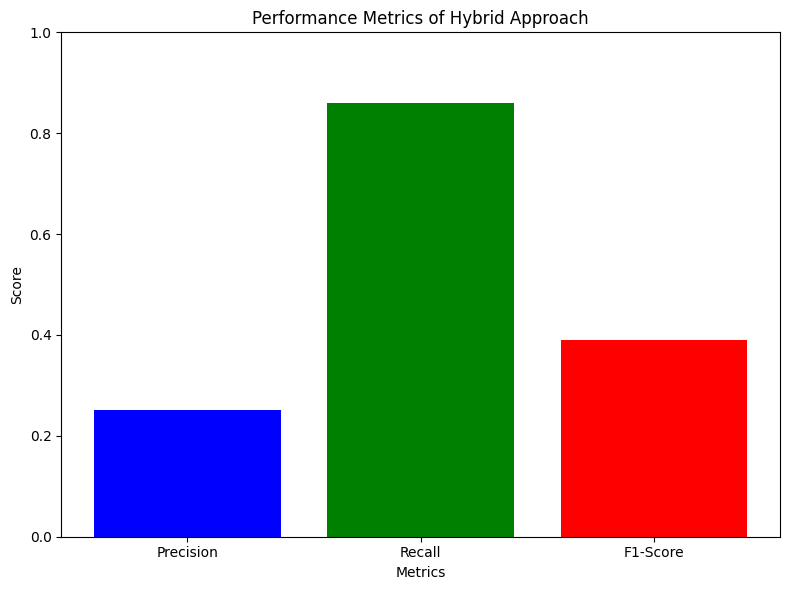

In [ ]:
plot_metrics(hybrid_metrics, 'Hybrid Approach')


# **Knowledge-Based Recommendations**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Preprocessing genres
df_anime['genre'] = df_anime['genre'].fillna('')  # Fill missing genres with an empty string

# TF-IDF Vectorization of genres
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df_anime['genre'])

# Compute cosine similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Function to recommend anime based on a given anime index
def recommend_anime(anime_idx, cosine_sim=cosine_sim, num_recommendations=5):
    sim_scores = list(enumerate(cosine_sim[anime_idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:num_recommendations + 1]  # Skip the first (self-similarity)
    anime_indices = [i[0] for i in sim_scores]
    return df_anime.iloc[anime_indices][['name', 'genre', 'rating']]

# Example usage
anime_idx = 0  # Index of the anime for which recommendations are needed
recommended_anime = recommend_anime(anime_idx)
print(recommended_anime)


                                       name  \
5805            Wind: A Breath of Heart OVA   
6394           Wind: A Breath of Heart (TV)   
1111  Aura: Maryuuin Kouga Saigo no Tatakai   
1201         Angel Beats!: Another Epilogue   
1494                               Harmonie   

                                             genre  rating  
5805          Drama, Romance, School, Supernatural    6.35  
6394          Drama, Romance, School, Supernatural    6.14  
1111  Comedy, Drama, Romance, School, Supernatural    7.67  
1201                   Drama, School, Supernatural    7.63  
1494                   Drama, School, Supernatural    7.52  


In [ ]:
# Simulate user input for anime preferences
user_favorites = ['Action', 'Adventure']
preferred_anime = df_anime[df_anime['genre'].str.contains('|'.join(user_favorites))]

# Generate recommendations for these genres
recommended_anime_ids = preferred_anime['anime_id'].tolist()

# Create a ground truth of user interactions for evaluation
ground_truth = df[df['anime_id'].isin(recommended_anime_ids)]

# Predicted relevance: Assume all recommended anime are relevant
predicted_relevance = [1] * len(recommended_anime_ids)

# Actual relevance based on user ratings
actual_relevance = [1 if rating >= 7 else 0 for rating in ground_truth['user_rating']]

# Ensure same length for metrics calculation
min_length = min(len(predicted_relevance), len(actual_relevance))
predicted_relevance = predicted_relevance[:min_length]
actual_relevance = actual_relevance[:min_length]

# Calculate metrics
precision = precision_score(actual_relevance, predicted_relevance)
recall = recall_score(actual_relevance, predicted_relevance)
f1 = f1_score(actual_relevance, predicted_relevance)

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Precision: 0.6278186565392831
Recall: 1.0
F1-score: 0.7713619130941965


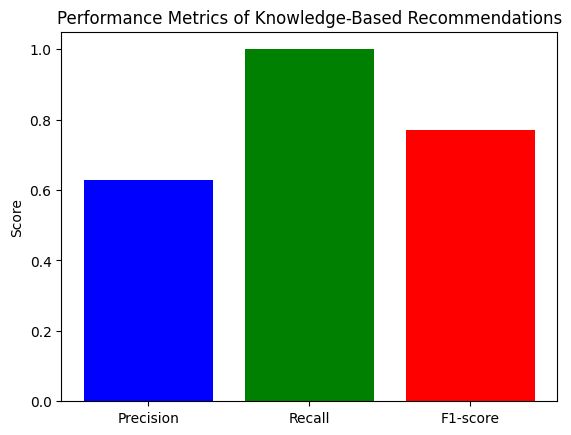

In [ ]:
# Visualize the metrics
plt.bar(['Precision', 'Recall', 'F1-score'], [precision, recall, f1], color=['blue', 'green', 'red'])
plt.title('Performance Metrics of Knowledge-Based Recommendations')
plt.ylabel('Score')
plt.show()